# **Tutorial 9: Thresholds**

**Week 2, Day 4, Extremes & Vulnerability**

**Content creators:** Matthias Aengenheyster, Joeri Reinders

**Content reviewers:** Younkap Nina Duplex, Sloane Garelick, Zahra Khodakaramimaghsoud, Peter Ohue, Laura Paccini, Jenna Pearson, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

In this 9th tutorial we will look at extreme levels spatially, and consider the importance of thresholds. 

By the end of the tutorial you will be able to:
1. Assess the risk of increasing wet bulb temperatures.
2. Analyse how the probability of crossing threshold changes over time and between scenarios.
3. Analyse the results of a spatial GEV analysis

# **Setup**

In [2]:
# Installs

In [3]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [4]:
# #install dependencies - taken from <Yosmely Bermúdez> comments for Tutorial 6
# # We need this to install eigen which is needed for SDFC to install correctly
# !mamba install eigen numpy matplotlib seaborn pandas cartopy scipy texttable intake xarrayutils xmip cf_xarray intake-esm
# !pip install -v https://github.com/yrobink/SDFC/archive/master.zip#subdirectory=python
# !pip install https://github.com/njleach/mystatsfunctions/archive/master.zip


In [1]:
# imports
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pandas as pd
import seaborn as sns
import cmocean.cm as cmo

import os

#import cftime
#import nc_time_axis

import numpy as np
import cartopy.crs as ccrs
from scipy import stats
from scipy.stats import genextreme as gev

# import extremes_functions as ef
import gev_functions as gf
# from mystatsfunctions import OLSE,LMoments
# import SDFC as sd

Note that `import gev_functions as gf` imports the functions introduced in Tutorial 7.

In [ ]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [ ]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

In [2]:
# def estimate_return_level(quantile,loc,scale,shape):
#     level = loc + scale / shape * (1 - (-np.log(quantile))**(shape))
#     return level

# **Section 1**
The human body has physiological limits within which it can function. In hot conditions, the body cools itself through the process of sweating, where water evaporates from the skin, resulting in the loss of heat. The effectiveness of this cooling mechanism depends on the air's capacity to hold moisture. This is why sweating is more effective in dry heat, while humid heat feels "hotter" because it hampers the body's ability to cool down.

As a result, the combination of temperature and humidity sets limits on the body's ability to regulate its temperature. One measure that captures this combined effect is the "wet bulb temperature," which refers to the reading on a thermometer wrapped in a wet sock. You can learn more about wet bulb temperature on the following Wikipedia page: [Wet-bulb temperature](https://en.wikipedia.org/wiki/Wet-bulb_temperature).

In this tutorial, we will utilize wet bulb temperature data derived from the MPI-ESM1-2-HR climate model, developed by the Max Planck Institute for Meteorology in Hamburg, Germany. The data covers the historical period (hist) as well as three future climate scenarios (SSP-126, SSP-245, and SSP-585). These scenarios were introduced in tutorial 7.

During the pre-processing phase, the data was subjected to a 7-day averaging process, followed by the computation of the annual maximum. As a result, the data for each grid point represents the wet bulb temperature during the most extreme 7-day period within each year.

In [2]:
import os, pooch

fname = 'WBGT_day_MPI-ESM1-2-HR_historical_r1i1p1f1_raw_runmean7_yearmax.nc'
if not os.path.exists(fname):
    url = "https://osf.io/69ms8/download"
    fname = pooch.retrieve(url, known_hash=None)

wetbulb_hist = xr.open_dataset(fname).WBGT

The dataset consists of one entry per year. However, due to the inclusion of leap years, the data processing step resulted in different days assigned to each year. This discrepancy is deemed undesirable for analysis purposes. To address this, we resampled the data by grouping all the data points belonging to each year and taking their average. Since there is only one data point per year, this resampling process does not alter the data itself, but rather adjusts the time coordinate. This serves as a reminder to thoroughly inspect datasets before analysis, as overlooking such issues can lead to workflow failures.

In [3]:
wetbulb_hist = wetbulb_hist.resample(time='1Y').mean()

Let's load the data for the remaining scenarios:

In [4]:
# SSP-126
fname = 'WBGT_day_MPI-ESM1-2-HR_ssp126_r1i1p1f1_raw_runmean7_yearmax.nc'
if not os.path.exists(fname):
    url = "https://osf.io/67b8m/download"
    fname = pooch.retrieve(url, known_hash=None)
    
wetbulb_126  = xr.open_dataset(fname).WBGT
wetbulb_126 = wetbulb_126.resample(time='1Y').mean()

# SSP-245
fname = 'WBGT_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_raw_runmean7_yearmax.nc'
if not os.path.exists(fname):
    url = "https://osf.io/fsx5y/download"
    fname = pooch.retrieve(url, known_hash=None)
    
wetbulb_245 = xr.open_dataset(fname).WBGT
wetbulb_245 = wetbulb_245.resample(time='1Y').mean()

# SSP-585
fname = 'WBGT_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_raw_runmean7_yearmax.nc'
if not os.path.exists(fname):
    url = "https://osf.io/pr456/download"
    fname = pooch.retrieve(url, known_hash=None)
    
wetbulb_585 = xr.open_dataset(fname).WBGT
wetbulb_585 = wetbulb_585.resample(time='1Y').mean()

Let's look at how the data is structured:

In [5]:
wetbulb_hist

<xarray.DataArray 'WBGT' (time: 64, lat: 192, lon: 384)>
array([[[-2.7235170e+01, -2.7209024e+01, -2.7091408e+01, ...,
         -2.7226376e+01, -2.7160492e+01, -2.7258596e+01],
        [-2.5137434e+01, -2.5155724e+01, -2.5227873e+01, ...,
         -2.5103416e+01, -2.5114450e+01, -2.5129984e+01],
        [-2.5405684e+01, -2.5478939e+01, -2.5416683e+01, ...,
         -2.5355572e+01, -2.5436531e+01, -2.5436386e+01],
        ...,
        [ 1.5202777e-01,  1.4101627e-01,  1.3330752e-01, ...,
          1.7247404e-01,  1.6777755e-01,  1.6128926e-01],
        [ 1.4682470e-01,  1.4339085e-01,  1.3746151e-01, ...,
          1.5303101e-01,  1.5185688e-01,  1.4891100e-01],
        [-6.8249358e-03, -7.0434422e-03, -8.7905107e-03, ...,
         -3.0952338e-03, -4.2250594e-03, -4.9193455e-03]],

       [[-2.6649139e+01, -2.6630531e+01, -2.6634752e+01, ...,
         -2.6691322e+01, -2.6607746e+01, -2.6625118e+01],
        [-2.5106850e+01, -2.5126314e+01, -2.5193607e+01, ...,
         -2.5092865e+01, -2.5098398e+01, -2.5103617e+01],
        [-2.5217392e+01, -2.5242710e+01, -2.5172596e+01, ...,
         -2.5080139e+01, -2.5190296e+01, -2.5223970e+01],
...
        [ 1.3378739e-01,  1.2870540e-01,  1.2770343e-01, ...,
          1.3989741e-01,  1.3784374e-01,  1.3685331e-01],
        [-4.5141011e-02, -4.6595134e-02, -5.1650975e-02, ...,
         -3.2980740e-02, -3.6983781e-02, -3.9977543e-02],
        [-1.8091998e-01, -1.8206993e-01, -1.8259056e-01, ...,
         -1.7845529e-01, -1.7992011e-01, -1.8005356e-01]],

       [[-2.5719893e+01, -2.5728792e+01, -2.5699797e+01, ...,
         -2.5871269e+01, -2.5829645e+01, -2.5588160e+01],
        [-2.3168945e+01, -2.3186224e+01, -2.3241858e+01, ...,
         -2.3076477e+01, -2.3144035e+01, -2.3166027e+01],
        [-2.2229086e+01, -2.2260471e+01, -2.2476068e+01, ...,
         -2.2073126e+01, -2.2129398e+01, -2.2191292e+01],
        ...,
        [-4.8862319e-02, -6.1266027e-02, -7.4026965e-02, ...,
         -1.7235180e-02, -2.6744476e-02, -3.6429971e-02],
        [-1.0998243e-01, -1.1364387e-01, -1.1661023e-01, ...,
         -9.9768467e-02, -1.0286019e-01, -1.0498482e-01],
        [-1.9145221e-01, -1.9040416e-01, -1.9016221e-01, ...,
         -1.9233751e-01, -1.9196975e-01, -1.9151381e-01]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * time     (time) datetime64[ns] 1951-12-31 1952-12-31 ... 2014-12-31
Attributes:
    long_name:         Wet bulb globe temperature
    units:             1
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  96
    cell_methods:      time: maximum

There is one data point per year on a latitude-longitude grid. Let's compute the grid spacing in the longitude and latitude directions:

In [6]:
wetbulb_hist.lon.diff('lon').values.mean()

0.9375

In [7]:
wetbulb_hist.lat.diff('lat').values.mean()

0.9349133773038073

Each grid box in the dataset has an approximate size of 1 degree by 1 degree, which translates to about 100 km by 100 km at the equator. However, this size decreases as we move towards the poles due to the convergence of the meridians. It is important to consider the limitations imposed by this grid resolution.

As a result, at the equator, the grid boxes cover an area of approximately 100 km by 100 km, while their size decreases in the mid-latitudes.

Considering these grid box limitations, can you identify any potential limitations or challenges they may introduce in the analysis?

## **Section 1.1: Focus on New Delhi, India**

In [8]:
wetbulb_hist_delhi = wetbulb_hist.sel(lon=77.21,lat=28.61,method='nearest')
wetbulb_126_delhi = wetbulb_126.sel(lon=77.21,lat=28.61,method='nearest')
wetbulb_245_delhi = wetbulb_245.sel(lon=77.21,lat=28.61,method='nearest')
wetbulb_585_delhi = wetbulb_585.sel(lon=77.21,lat=28.61,method='nearest')

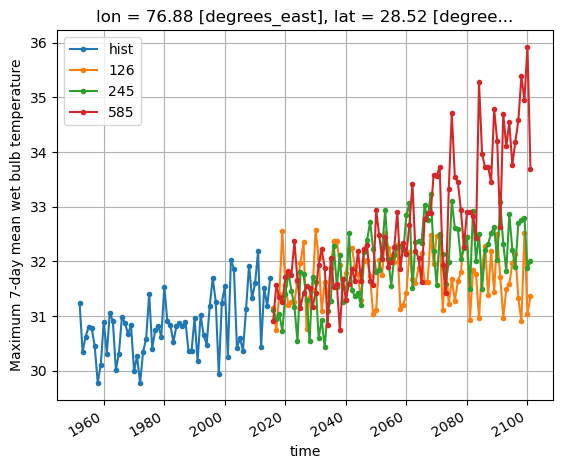

In [9]:
wetbulb_hist_delhi.plot.line('.-',label='hist')
wetbulb_126_delhi.plot.line('.-',label='126')
wetbulb_245_delhi.plot.line('.-',label='245')
wetbulb_585_delhi.plot.line('.-',label='585')

plt.legend()
plt.ylabel('Maximum 7-day mean wet bulb temperature')
plt.grid(True)

Note:
1. Trends are visible in the historical period
2. Clear differences between climate scenarios which become apparent at some point
3. Strong variability - each year is not necessarily warmer than the previous one

In [11]:
fit_hist, model_hist = ef.fit_return_levels_sdfc(wetbulb_hist_delhi.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=100,full=True,model=True)


In [23]:
shape_hist, loc_hist, scale_hist = gev.fit(wetbulb_hist_delhi.values,0)
return_levels_hist = gf.fit_return_levels(wetbulb_hist_delhi.values, years = np.arange(1.1,1000),N_boot=100)

Location: 3.1e+01, scale: 5.0e-01, shape: 1.6e-01
Ranges with alpha=0.050 :
Location: [30.46 , 30.75]
Scale: [0.42 , 0.60]
Shape: [0.00 , 0.31]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


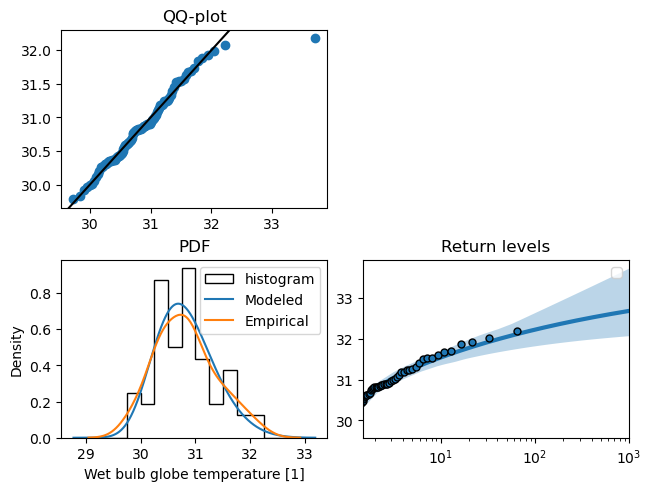

In [12]:
fig, axs = plt.subplots(2,2,constrained_layout=True)
ax = axs.flatten()

x = np.linspace(0,1,100)
ax[0].plot(gev.ppf(x, shape_hist, loc=loc_hist, scale=scale_hist), np.quantile(wetbulb_hist_delhi,x),'o')
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],[min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],'k')

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)


x = np.linspace(wetbulb_hist_delhi.min()-1, wetbulb_hist_delhi.max()+1, 1000)
wetbulb_hist_delhi.plot.hist(bins=np.arange(29,33,0.25),histtype='step',density=True,lw=1,color='k',ax=ax[2],label='histogram')
ax[2].plot(x,gev.pdf(x, shape_hist, loc=loc_hist, scale=scale_hist), label='Modeled')
sns.kdeplot(wetbulb_hist_delhi,ax=ax[2],label='Empirical')
ax[2].legend()

# ef.plot_levels_from_obj(fit_hist,alpha=0.95,ax=ax[3])
gf.plot_return_levels(return_levels_hist,ax=ax[3])
ax[3].set_xlim(1.5,1000)
# ax[3].set_ylim(0,None)

ax[0].set_title('QQ-plot')
ax[2].set_title('PDF')
ax[3].set_title('Return levels')

ax[1].remove()

In [14]:
print('100-year return level: %.2f' % gf.estimate_return_level_period(100,loc_hist,scale_hist,shape_hist))

100-year return level: 32.23


Now let's compare with the last 30 years of the SSP-245 scenario, the middle scenario we looked at before. 2050-2100 are approximately stationary here

In [54]:
shape_245, loc_245, scale_245 = gev.fit(wetbulb_245_delhi.sel(time=slice('2070','2100')).values,0)
return_levels_245 = gf.fit_return_levels(wetbulb_245_delhi.sel(time=slice('2070','2100')).values, years = np.arange(1.1,1000),N_boot=100)

Location: 3.2e+01, scale: 4.5e-01, shape: 3.8e-01
Ranges with alpha=0.050 :
Location: [31.98 , 32.44]
Scale: [0.32 , 0.60]
Shape: [0.00 , 0.92]


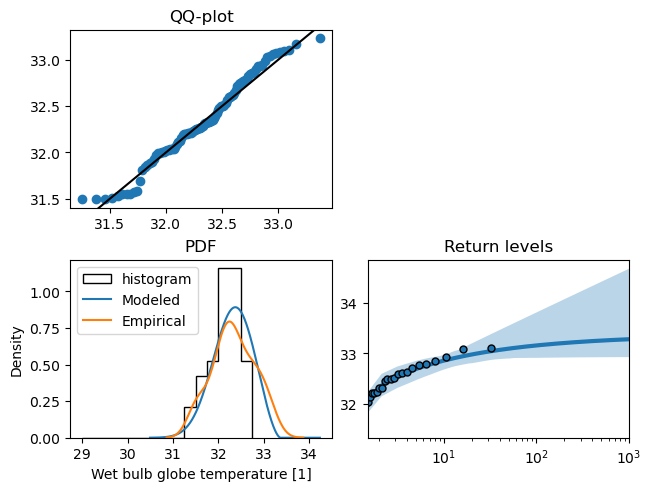

In [55]:
fig, axs = plt.subplots(2,2,constrained_layout=True)
ax = axs.flatten()

x = np.linspace(0,1,100)
ax[0].plot(gev.ppf(x, shape_245, loc=loc_245, scale=scale_245), np.quantile(wetbulb_245_delhi.sel(time=slice('2051','2100')),x),'o')
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],[min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],'k')

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)


x = np.linspace(wetbulb_245_delhi.sel(time=slice('2051','2100')).min()-1, wetbulb_245_delhi.sel(time=slice('2051','2100')).max()+1, 1000)
wetbulb_245_delhi.sel(time=slice('2051','2100')).plot.hist(bins=np.arange(29,33,0.25),histtype='step',density=True,lw=1,color='k',ax=ax[2],label='histogram')
ax[2].plot(x,gev.pdf(x, shape_245, loc=loc_245, scale=scale_245), label='Modeled')
sns.kdeplot(wetbulb_245_delhi.sel(time=slice('2051','2100')),ax=ax[2],label='Empirical')
ax[2].legend()

gf.plot_return_levels(return_levels_245,ax=ax[3])
ax[3].set_xlim(1.5,1000)
# ax[3].set_ylim(0,None)

ax[0].set_title('QQ-plot')
ax[2].set_title('PDF')
ax[3].set_title('Return levels')

ax[1].remove()

In [56]:
print('100-year return level: %.2f' % gf.estimate_return_level_period(100,loc_245,scale_245,shape_245))

100-year return level: 33.16


Compute as well the fit for the remaining two scenarios (SSP-126 and SSP-585).
You can then plot all results together to compare

In [57]:
return_levels_126 = gf.fit_return_levels(wetbulb_126_delhi.sel(time=slice('2070','2100')).values, years = np.arange(1.1,1000),N_boot=100)
return_levels_585 = gf.fit_return_levels(wetbulb_585_delhi.sel(time=slice('2070','2100')).values, years = np.arange(1.1,1000),N_boot=100)

Location: 3.2e+01, scale: 5.0e-01, shape: 3.1e-01
Ranges with alpha=0.050 :
Location: [31.22 , 31.93]
Scale: [0.31 , 0.84]
Shape: [-0.25 , 1.12]
Location: 3.3e+01, scale: 1.1e+00, shape: 3.3e-01
Ranges with alpha=0.050 :
Location: [33.05 , 33.84]
Scale: [0.79 , 1.35]
Shape: [0.17 , 0.59]


Text(0, 0.5, 'return level (degrees)')

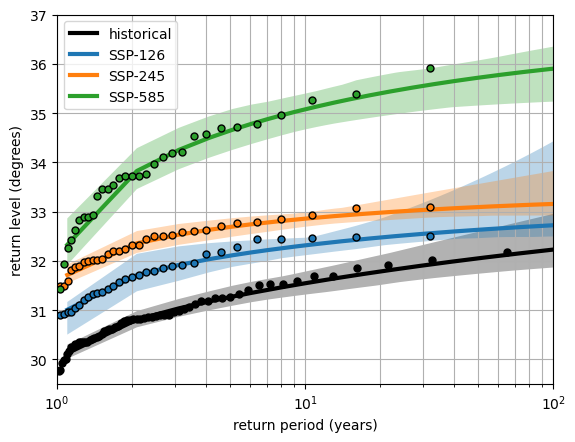

In [63]:
gf.plot_return_levels(return_levels_hist,c='k',label='historical')
gf.plot_return_levels(return_levels_126,c='C0',label='SSP-126')
gf.plot_return_levels(return_levels_245,c='C1',label='SSP-245')
gf.plot_return_levels(return_levels_585,c='C2',label='SSP-585')

plt.xlim(1,100)
plt.ylim(29.5,37)
plt.legend()
plt.grid(True,which='both')
plt.xlabel('return period (years)')
plt.ylabel('return level (degrees)')

## Exercise: 
Compare the common (return period << 10 years) to the very rate (return period ~ 100 years) events under the different scenarios.

What is the return level of a 3-year event under the SSP-585 scenario? Note down the level. What would be the return period of such an event in the other scenarios?

What is the return level of a 100-year event in the historical scenario. How often would such an event occur under the other scenarios?

## **Section 1.2a: Return levels over different intervals**

Besides the late period (2070-2011), compute the return levels over the near future (2015-2050). Then let's plot the timeseries, and overlay the 100-year return level, as computed over 2015-2050, 2070-2100, and the historical period:

In [32]:
return_levels_126_2015_2050 = gf.fit_return_levels(wetbulb_126_delhi.sel(time=slice('2015','2050')).values, years = np.arange(1.1,1000),N_boot=100)
return_levels_245_2015_2050 = gf.fit_return_levels(wetbulb_245_delhi.sel(time=slice('2015','2050')).values, years = np.arange(1.1,1000),N_boot=100)
return_levels_585_2015_2050 = gf.fit_return_levels(wetbulb_585_delhi.sel(time=slice('2015','2050')).values, years = np.arange(1.1,1000),N_boot=100)

Location: 3.2e+01, scale: 5.0e-01, shape: 3.1e-01
Ranges with alpha=0.050 :
Location: [31.18 , 32.06]
Scale: [0.32 , 0.84]
Shape: [-0.43 , 1.14]
Location: 3.2e+01, scale: 4.5e-01, shape: 3.8e-01
Ranges with alpha=0.050 :
Location: [32.00 , 32.46]
Scale: [0.32 , 0.59]
Shape: [0.00 , 0.86]
Location: 3.3e+01, scale: 1.1e+00, shape: 3.3e-01
Ranges with alpha=0.050 :
Location: [33.05 , 33.72]
Scale: [0.71 , 1.29]
Shape: [0.15 , 0.70]
Location: 3.2e+01, scale: 4.9e-01, shape: 3.6e-01
Ranges with alpha=0.050 :
Location: [31.31 , 31.72]
Scale: [0.34 , 0.63]
Shape: [0.00 , 0.72]
Location: 3.1e+01, scale: 5.5e-01, shape: 2.4e-01
Ranges with alpha=0.050 :
Location: [31.07 , 31.48]
Scale: [0.38 , 0.70]
Shape: [0.00 , 0.52]
Location: 3.1e+01, scale: 4.4e-01, shape: 1.8e-01
Ranges with alpha=0.050 :
Location: [31.39 , 31.69]
Scale: [0.33 , 0.52]
Shape: [0.00 , 0.59]


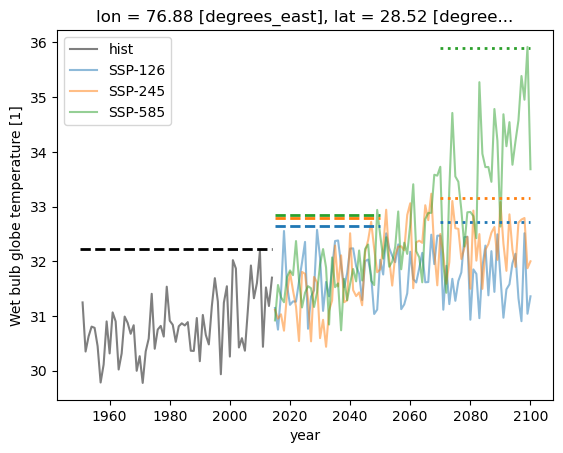

In [64]:
wetbulb_hist_delhi.groupby('time.year').mean().plot.line(alpha=0.5,c='k',label='hist')
wetbulb_126_delhi.groupby('time.year').mean().plot.line(alpha=0.5,c='C0',label='SSP-126')
wetbulb_245_delhi.groupby('time.year').mean().plot.line(alpha=0.5,c='C1',label='SSP-245')
wetbulb_585_delhi.groupby('time.year').mean().plot.line(alpha=0.5,c='C2',label='SSP-585')
plt.legend()
plt.hlines(
    return_levels_hist.GEV.sel(period=100,method='nearest').values,
    1950,2014,
    'k',linestyle='--',lw=2)

# plt.hlines(
#     return_levels_126.GEV.sel(period=100,method='nearest').values,
#     2015,2100,
#     'C0',linestyle='--',lw=2)
# plt.hlines(
#     return_levels_245.GEV.sel(period=100,method='nearest').values,
#     2015,2100,
#     'C1',linestyle='--',lw=2)
# plt.hlines(
#     return_levels_585.GEV.sel(period=100,method='nearest').values,
#     2015,2100,
#     'C2',linestyle='--',lw=2)

plt.hlines(
    return_levels_126_2015_2050.GEV.sel(period=100,method='nearest').values,
    2015,2050,
    'C0',linestyle='--',lw=2)
plt.hlines(
    return_levels_245_2015_2050.GEV.sel(period=100,method='nearest').values,
    2015,2050,
    'C1',linestyle='--',lw=2)
plt.hlines(
    return_levels_585_2015_2050.GEV.sel(period=100,method='nearest').values,
    2015,2050,
    'C2',linestyle='--',lw=2)

plt.hlines(
    return_levels_126.GEV.sel(period=100,method='nearest').values,
    2070,2100,
    'C0',linestyle=':',lw=2)
plt.hlines(
    return_levels_245.GEV.sel(period=100,method='nearest').values,
    2070,2100,
    'C1',linestyle=':',lw=2)
plt.hlines(
    return_levels_585.GEV.sel(period=100,method='nearest').values,
    2070,2100,
    'C2',linestyle=':',lw=2)


## **Section 1.2: Time-dependent return levels**

Now, similar to the previous tutorial, we assume that the location parameter is a function of time and proceed to estimate the GEV distribution for the four scenarios:

In [66]:
import SDFC as sd

In [77]:
def estimate_return_level_model(quantile,model):
    loc, scale, shape = model.loc, model.scale, model.shape
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    # level = stats.genextreme.ppf(quantile,-shape,loc=loc,scale=scale)
    return level

In [70]:
law_ns_hist = sd.GEV()
law_ns_hist.fit(wetbulb_hist_delhi.values, c_loc = np.arange(wetbulb_hist_delhi.time.size))

law_ns_126 = sd.GEV()
law_ns_126.fit(wetbulb_126_delhi.values, c_loc = np.arange(wetbulb_126_delhi.time.size))

law_ns_126 = sd.GEV()
law_ns_126.fit(wetbulb_126_delhi.values, c_loc = np.arange(wetbulb_126_delhi.time.size))

law_ns_245 = sd.GEV()
law_ns_245.fit(wetbulb_245_delhi.values, c_loc = np.arange(wetbulb_245_delhi.time.size))

law_ns_585 = sd.GEV()
law_ns_585.fit(wetbulb_585_delhi.values, c_loc = np.arange(wetbulb_585_delhi.time.size))

/home/a/aengenheyster/nobackups/bin/conda/envs/climatematch/lib/python3.11/site-packages/SDFC-0.6.0.post1-py3.11-linux-x86_64.egg/SDFC/__GEV.py:332: RuntimeWarning: invalid value encountered in power
  ZZi   = np.power( ZZ ,  - 1 / shape )
/home/a/aengenheyster/nobackups/bin/conda/envs/climatematch/lib/python3.11/site-packages/SDFC-0.6.0.post1-py3.11-linux-x86_64.egg/SDFC/__GEV.py:333: RuntimeWarning: invalid value encountered in power
  ZZim1 = np.power( ZZ ,  - shc )
/home/a/aengenheyster/nobackups/bin/conda/envs/climatematch/lib/python3.11/site-packages/SDFC-0.6.0.post1-py3.11-linux-x86_64.egg/SDFC/__GEV.py:342: RuntimeWarning: invalid value encountered in log
  T2 = np.log(ZZ) * ZZi / shape**2 - ZZim1 * Z / shape - np.log(ZZ) / shape**2 + shc * Z / ZZ
/home/a/aengenheyster/nobackups/bin/conda/envs/climatematch/lib/python3.11/site-packages/SDFC-0.6.0.post1-py3.11-linux-x86_64.egg/SDFC/__GEV.py:332: RuntimeWarning: invalid value encountered in power
  ZZi   = np.power( ZZ ,  - 1 / sh

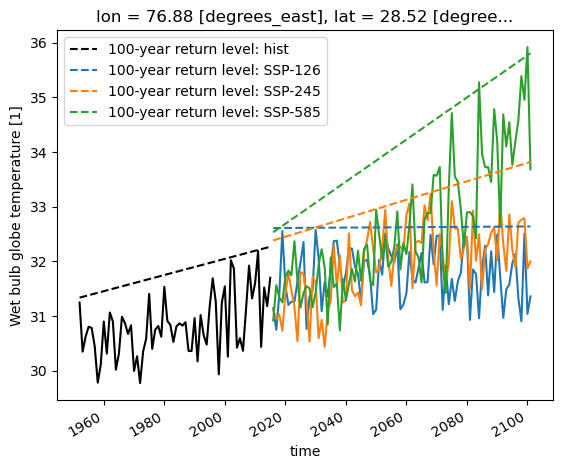

In [78]:
wetbulb_hist_delhi.plot.line(c='k')
wetbulb_126_delhi.plot.line(c='C0')
wetbulb_245_delhi.plot.line(c='C1')
wetbulb_585_delhi.plot.line(c='C2')

plt.plot(wetbulb_hist_delhi.time,estimate_return_level_model(1-1/100,law_ns_hist),'k--',label='100-year return level: hist')
plt.plot(wetbulb_126_delhi.time,estimate_return_level_model(1-1/100,law_ns_126),'C0--',label='100-year return level: SSP-126')
plt.plot(wetbulb_245_delhi.time,estimate_return_level_model(1-1/100,law_ns_245),'C1--',label='100-year return level: SSP-245')
plt.plot(wetbulb_585_delhi.time,estimate_return_level_model(1-1/100,law_ns_585),'C2--',label='100-year return level: SSP-585')

plt.legend()

Now we again compute the AIC for the constant and time-dependent models, and compare their performance:

In [88]:
def compute_aic(model):
    return 2 * len(model.coef_) + 2 * model.info_.mle_optim_result.fun

In [91]:
import warnings
warnings.filterwarnings('ignore')
# compute stationary models:
law_ss_hist = sd.GEV()
law_ss_hist.fit(wetbulb_hist_delhi.values)

law_ss_126 = sd.GEV()
law_ss_126.fit(wetbulb_126_delhi.values)

law_ss_126 = sd.GEV()
law_ss_126.fit(wetbulb_126_delhi.values)

law_ss_245 = sd.GEV()
law_ss_245.fit(wetbulb_245_delhi.values)

law_ss_585 = sd.GEV()
law_ss_585.fit(wetbulb_585_delhi.values)

In [94]:
aics = pd.DataFrame(columns=['hist','ssp126','ssp245','ssp585'],index=['constant','covariate'])

aics['hist'] = compute_aic(law_ss_hist), compute_aic(law_ns_hist)
aics['ssp126'] = compute_aic(law_ss_126), compute_aic(law_ns_126)
aics['ssp245'] = compute_aic(law_ss_245), compute_aic(law_ns_245)
aics['ssp585'] = compute_aic(law_ss_585), compute_aic(law_ns_585)

In [95]:
aics.round(2)

,hist,ssp126,ssp245,ssp585
constant,108.71,122.02,174.87,261.98
covariate,96.58,123.99,136.84,179.08


The AIC is lower when using a covariate, suggesting that including the time-dependence into the location parameter improves the quality of the model.

# **Section 2: Spatial Analysis**

After looking at New Delhi, India, now we can make use of the spatial information:


The code provided below is commented and is used to fit the GEV distribution for each grid point. For the historical scenario, the entire time range is used, while for the selected scenarios, the period from 2071 to 2100 (the last 30 years of the data) is used.

Please note that the computation for this code takes some time (approximately 9 minutes per dataset). To save time, we have already precomputed the data, so there is no need to run the commented code. However, you are free to uncomment and run the code, make modifications, or include time-dependent parameters (as shown above) at your convenience. If desired, you can also focus on specific regions.

Expensive code that fits a GEV distribution to each grid point:

In [ ]:
# fit_sp_hist = ef.fit_return_levels_sdfc_2d(wetbulb_hist.rename({'lon':'longitude','lat':'latitude'}),times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=0,full=True)
# fit_sp_126 = ef.fit_return_levels_sdfc_2d(wetbulb_126.sel(time=slice('2071','2100')).rename({'lon':'longitude','lat':'latitude'}),times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=0,full=True)
# fit_sp_245 = ef.fit_return_levels_sdfc_2d(wetbulb_245.sel(time=slice('2071','2100')).rename({'lon':'longitude','lat':'latitude'}),times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=0,full=True)
# fit_sp_585 = ef.fit_return_levels_sdfc_2d(wetbulb_585.sel(time=slice('2071','2100')).rename({'lon':'longitude','lat':'latitude'}),times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=0,full=True)

## **Section 2.1: Load Pre-Computed Data**

In [28]:
# historical
fname = 'wbgt_hist_raw_runmean7_gev.nc'
if not os.path.exists(fname):
    url = "https://osf.io/dakv3/download"
    fname = pooch.retrieve(url, known_hash=None)
fit_sp_hist = xr.open_dataset(fname)

# SSP-126
fname = 'wbgt_126_raw_runmean7_gev_2071-2100.nc'
if not os.path.exists(fname):
    url = "https://osf.io/ef9pv/download"
    fname = pooch.retrieve(url, known_hash=None)
fit_sp_126 = xr.open_dataset(fname)

# SSP-245
fname = 'wbgt_245_raw_runmean7_gev_2071-2100.nc'
if not os.path.exists(fname):
    url = "https://osf.io/j4hfc/download"
    fname = pooch.retrieve(url, known_hash=None)
fit_sp_245 = xr.open_dataset(fname)

# SSP-585
fname = 'wbgt_585_raw_runmean7_gev_2071-2100.nc'
if not os.path.exists(fname):
    url = "https://osf.io/y6edw/download"
    fname = pooch.retrieve(url, known_hash=None)
fit_sp_585 = xr.open_dataset(fname)

Also load the area for each grid box - we will use this later to compute global averages:

In [29]:
fname = 'area_mpi.nc'
if not os.path.exists(fname):
    url = "https://osf.io/zqd86/download"
    fname = pooch.retrieve(url, known_hash=None)
area = xr.open_dataarray(fname)

fname = 'area_land_mpi.nc'
if not os.path.exists(fname):
    url = "https://osf.io/dxq98/download"
    fname = pooch.retrieve(url, known_hash=None)
area_land = xr.open_dataarray(fname).fillna(0.)

Now, let's examine the 100-year return level in the historical run and compare it to the period from 2071-2100 in the three scenarios. The colorbar has been set to start at 28 degrees, which is approximately the temperature reached during the severe heatwaves in Europe in 2003 and Russia in 2010.

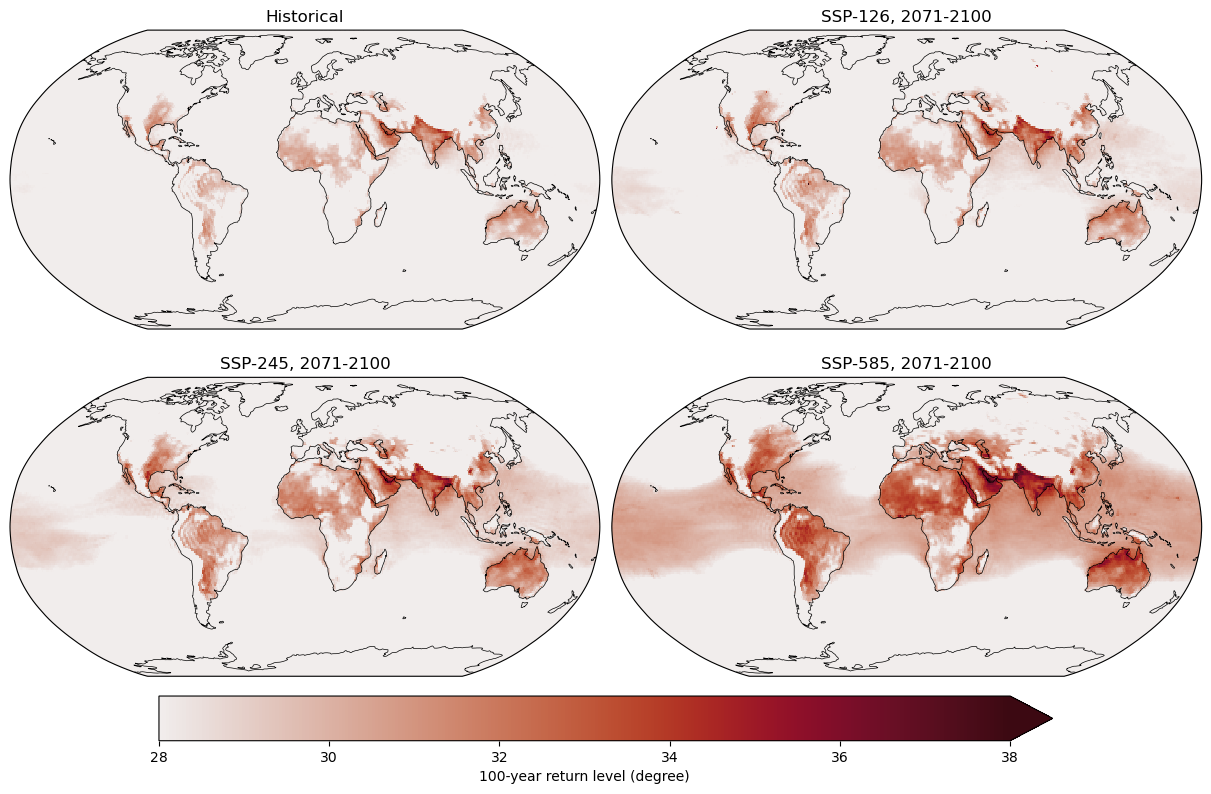

In [31]:
fig, axs = plt.subplots(2,2,constrained_layout=True,figsize=(12,8),subplot_kw=dict(projection=ccrs.Robinson()))
ax = axs.flatten()

kwargs = dict(
    vmin=28,
    vmax=38,
    cmap=cmo.amp,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

p = fit_sp_hist['return level'].sel({'return period':100},method='nearest').plot(ax=ax[0],**kwargs)
fit_sp_126['return level'].sel({'return period':100},method='nearest').plot(ax=ax[1],**kwargs)
fit_sp_245['return level'].sel({'return period':100},method='nearest').plot(ax=ax[2],**kwargs)
fit_sp_585['return level'].sel({'return period':100},method='nearest').plot(ax=ax[3],**kwargs)

cbar = fig.colorbar(p,ax=ax,pad=0.025,orientation='horizontal',shrink=0.75,label='100-year return level (degree)',extend='max')

ax[0].set_title('Historical')
ax[1].set_title('SSP-126, 2071-2100')
ax[2].set_title('SSP-245, 2071-2100')
ax[3].set_title('SSP-585, 2071-2100')

[axi.set_facecolor('grey') for axi in ax]
[axi.coastlines(lw=0.5) for axi in ax]

The following plot gives a red shading to regions where the hottest heatwave is above 31 degrees wet bulb temperature, which is considered a "critical temperature" above which a human will die within a few hours:

Text(0.5, 0.98, 'Shaded regions for most extreme heatwave is > 31 WBGT')

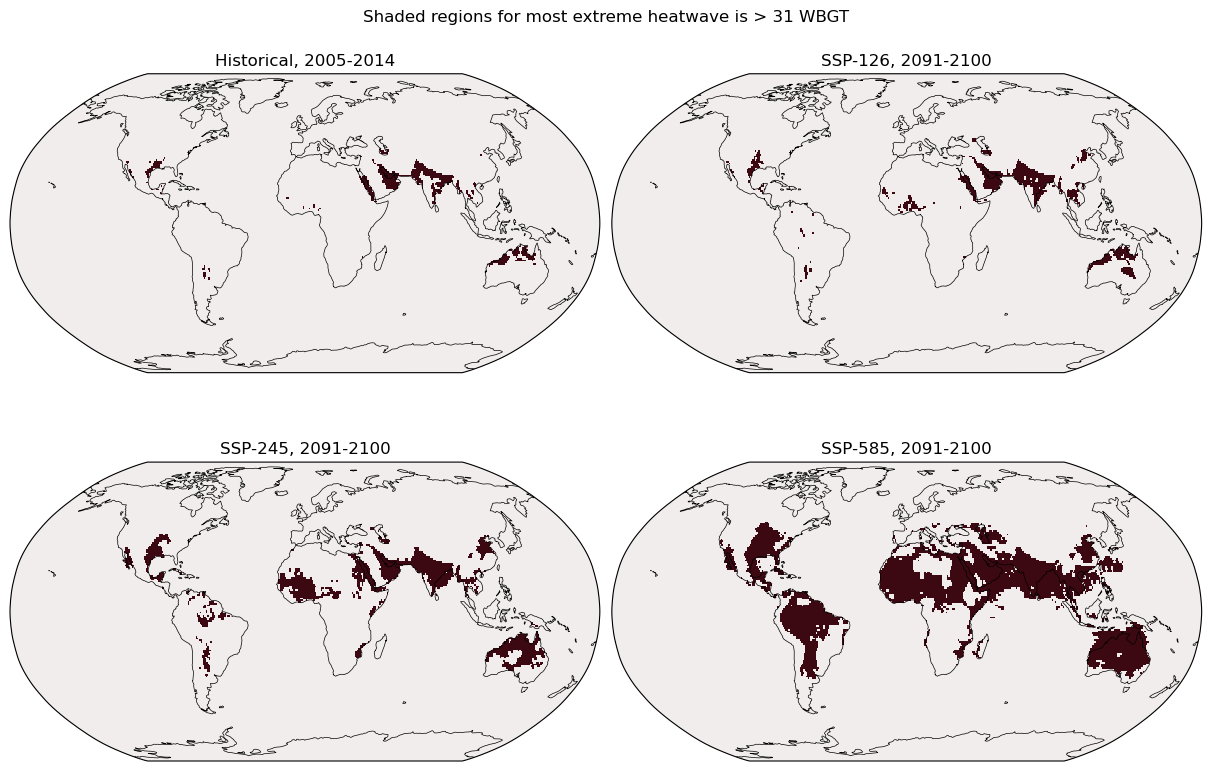

In [59]:
fig, axs = plt.subplots(2,2,constrained_layout=True,figsize=(12,8),subplot_kw=dict(projection=ccrs.Robinson()))
ax = axs.flatten()

kwargs = dict(
    vmin=0,
    # vmin=20,
    # vmax=37,
    cmap=cmo.amp,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

p = (wetbulb_hist.sel(time=slice('2005','2014')).max('time')>31).plot(ax=ax[0],**kwargs)
(wetbulb_126.sel(time=slice('2091','2100')).max('time')>31).plot(ax=ax[1],**kwargs)
(wetbulb_245.sel(time=slice('2091','2100')).max('time')>31).plot(ax=ax[2],**kwargs)
(wetbulb_585.sel(time=slice('2091','2100')).max('time')>31).plot(ax=ax[3],**kwargs)

# cbar = fig.colorbar(p,ax=ax,pad=0.025,orientation='horizontal',shrink=0.75,label='Most extreme 7-day mean WBGT')

ax[0].set_title('Historical, 2005-2014')
ax[1].set_title('SSP-126, 2091-2100')
ax[2].set_title('SSP-245, 2091-2100')
ax[3].set_title('SSP-585, 2091-2100')

[axi.set_facecolor('grey') for axi in ax]
[axi.coastlines(lw=0.5) for axi in ax]

fig.suptitle('Shaded regions for most extreme heatwave is > 31 WBGT')

Now we will examine the changes over time in the portion of the Earth's land surface affected by extreme heatwaves. To accomplish this, we utilize the previously loaded grid box area data.

Next, we assign a value of "1" to the temporal-spatial data if it surpasses the defined threshold, and a value of "0" if it does not. By conducting an area-weighted average across the entire land area of the world, we determine the fraction of land area experiencing a heatwave above the threshold for each year.

Text(0.5, 1.0, 'Fraction of land area with 7 days of wet bulb temperature > 31 degrees')

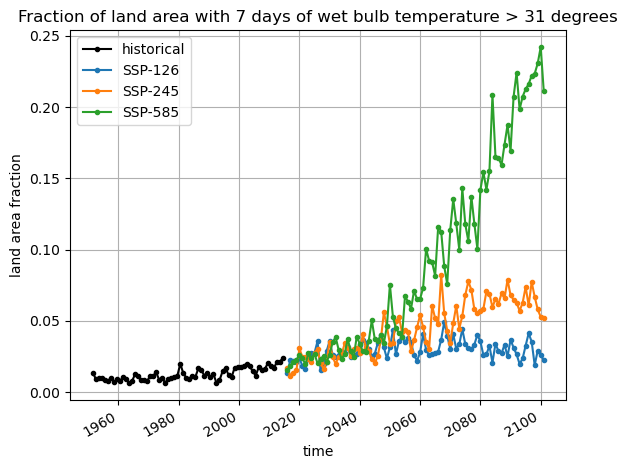

In [74]:
((wetbulb_hist>31)*1).weighted(area_land).mean(['lon','lat']).plot.line('k.-',label='historical')
((wetbulb_126>31)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-126')
((wetbulb_245>31)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-245')
((wetbulb_585>31)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-585')

plt.grid(True)

plt.legend()
plt.ylabel('land area fraction')
plt.title('Fraction of land area with 7 days of wet bulb temperature > 31 degrees')

In [43]:
print('Fraction of the land area of the world that experiences a heatwave above wet bulb temperature of 31 in the last 10 years of each run:')
(pd.Series(
    index=['historical','SSP-126','SSP-245','SSP-585'],
    data=[
    ((wetbulb_hist>31)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values,
    ((wetbulb_126>31)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values,
    ((wetbulb_245>31)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values,
    ((wetbulb_585>31)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values
    ]
).astype(float) * 100).round(2)

Fraction of the land area of the world that experiences a heatwave above wet bulb temperature of 31 in the last 10 years of each run:


historical     1.82
SSP-126        2.75
SSP-245        6.24
SSP-585       21.89
dtype: float64

###  **Questions 2.1** 
1. What observations can you make when examining the time evolution and comparing the different scenarios?
2. Repeat the analysis using several temperature thresholds, such as 31, 28, and 33 degrees. How does the relative difference between scenarios change when using higher or lower thresholds?


In [ ]:
# to_remove explanation
"""
We see that a smaller fraction of the Earth experiences more extreme heat waves - as expected.

However, the difference between the scenarios becomes larger for more extreme events:
The area fraction that experiences heat waves above 28 degrees increases by 51.05 / 20.68 = 2.46 times between historical and SSP-585 scenarios, but for heat waves above 33 degrees it is 5.18 / 0.15 = 34.53 times!
""";

# **Summary**
In this tutorial, we explored the concept of "wet bulb temperature" and its implications on human health under extreme heat conditions. We analyzed the likelihood of crossing critical thresholds under historical and future climate scenarios, using data from a specific climate model. We learned how to conduct a spatial GEV analysis and evaluated the potential human impact under extreme heatwaves. This marks the end of our study for today. Tomorrow, we'll shift our focus to the applications of data science and machine learning in addressing climate change, starting with regression techniques.